## Testing evolve tent pitching with solution
$$ \sin\left(ct+\sum_{i=1}^{dim} \sqrt{\frac{1}{dim}}x_i\right)$$

In [1]:
import sys
sys.path.append("..")
from ngsolve import *
SetHeapSize(100*1000*1000)

from ngsolve import *
from ngsolve.comp import *
from ngsolve.TensorProductTools import *
import netgen.meshing as ngm
from netgen.geom2d import unit_square
from netgen.csg import unit_cube
from trefftzngs import *
from DGeq import *
# import netgen.gui
import scipy as sp
import scipy.sparse.linalg
import scipy.linalg
import time
from scipy.io import savemat
from scipy.io import loadmat
from netgen.csg import unit_cube

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

## timing

In [2]:
t_start=0
order=3
c=3
t_end=1
initmesh = Mesh(unit_cube.GenerateMesh(maxh=0.4))
wavefront = EvolveTentsMakeWavefront(order,initmesh,c,t_start)
mat = EvolveTents(order,initmesh,c,t_end,wavefront,0)
l2err = EvolveTentsPostProcess(order,initmesh,mat,EvolveTentsMakeWavefront(order,initmesh,c,t_end))

for t in Timers():
    print(t)

{'name': 'tentcalcshape', 'time': 0.0, 'counts': 0, 'flops': 0, 'Gflop/s': nan}
{'name': 'tentint', 'time': 12.568312883377075, 'counts': 8405, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'tent', 'time': 21.238765716552734, 'counts': 841, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'pitch tents', 'time': 0.004475831985473633, 'counts': 1, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'CalcIdentifiedFacets', 'time': 1.9073486328125e-06, 'counts': 1, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'MeshAccess::UpdateBuffers', 'time': 3.504753112792969e-05, 'counts': 1, 'flops': 0, 'Gflop/s': 0.0}
{'name': 'H1FESpace::GetFE', 'time': 0.0, 'counts': 0, 'flops': 0, 'Gflop/s': nan}
{'name': 'SparseMatrixSymmetric::AddElementMatrix', 'time': 0.0, 'counts': 0, 'flops': 0, 'Gflop/s': nan}
{'name': 'SparseMatrix::AddElementMatrix', 'time': 0.0, 'counts': 0, 'flops': 0, 'Gflop/s': nan}
{'name': 'AddABt-double-complex, sym', 'time': 0.0, 'counts': 0, 'flops': 0, 'Gflop/s': nan}
{'name': 'AddABt-double-complex', 'time': 0.0, 'count

## p-convergence 

In [3]:
maxorder=5
c = 3
t_start = 0
t_end = 2
meshes = [Mesh(SegMesh(4,0,1)),\
          Mesh(unit_square.GenerateMesh(maxh=0.5)),\
          Mesh(unit_cube.GenerateMesh(maxh = 0.5))]

for initmesh in meshes:
    print("dim: " + str(initmesh.dim))
    for order in range(2,maxorder):
        wavefront = EvolveTentsMakeWavefront(order,initmesh,c,t_start)
        mat = EvolveTents(order,initmesh,c,t_end,wavefront,0)
        l2err = EvolveTentsPostProcess(order,initmesh,mat,EvolveTentsMakeWavefront(order,initmesh,c,t_end))
        print("order: " + str(order) + " err: " + str(l2err))

dim: 1
order: 2 err: 0.0011076226885610957
order: 3 err: 1.725520167542586e-05
order: 4 err: 1.7587892219158518e-06
dim: 2
order: 2 err: 0.011580582551544191
order: 3 err: 0.00032849491141270196
order: 4 err: 6.942782227500603e-05
dim: 3
order: 2 err: 0.01436249472779596
order: 3 err: 0.00043105310198277605
order: 4 err: 8.90997911554551e-05


## hp-convergence

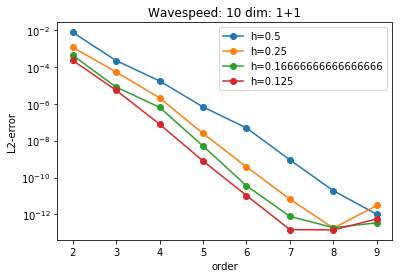

In [4]:
maxorder = 10
c = 10
t_start = 0
t_end = 10

fig = plt.figure()
ax = fig.gca()
for h in range(2,9,2):
    error = []
    initmesh = Mesh(SegMesh(h,0,1))
    for order in range(2,maxorder):
        wavefront = EvolveTentsMakeWavefront(order,initmesh,c,t_start)
        mat = EvolveTents(order,initmesh,c,t_end,wavefront,0)
        l2err = EvolveTentsPostProcess(order,initmesh,mat,EvolveTentsMakeWavefront(order,initmesh,c,t_end))
        error.append(l2err)
    plt.semilogy(range(2,maxorder) , error, '-o', label="h="+str(1/h))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Wavespeed: ' + str(c) + " dim: " + str(initmesh.dim) + "+1")
plt.legend()
plt.ylabel("L2-error")
plt.xlabel("order")
#plt.savefig("results/pvtv3_"+label[yaxis]+label[xaxis]+".png")
plt.show()

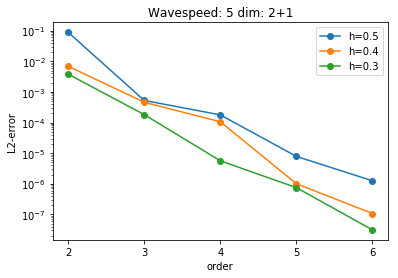

In [5]:
maxorder = 7
c = 5
t_start = 0
t_end = 5

fig = plt.figure()
ax = fig.gca()
for h in [0.5,0.4,0.3]:
    error = []
    initmesh = Mesh(unit_square.GenerateMesh(maxh=h))
    for order in range(2,maxorder):
        wavefront = EvolveTentsMakeWavefront(order,initmesh,c,t_start)
        mat = EvolveTents(order,initmesh,c,t_end,wavefront,0)
        l2err = EvolveTentsPostProcess(order,initmesh,mat,EvolveTentsMakeWavefront(order,initmesh,c,t_end))
        error.append(l2err)
    plt.semilogy(range(2,maxorder) , error, '-o', label="h="+str(h))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Wavespeed: ' + str(c) + " dim: " + str(initmesh.dim) + "+1")
plt.legend()
plt.ylabel("L2-error")
plt.xlabel("order")
plt.show()

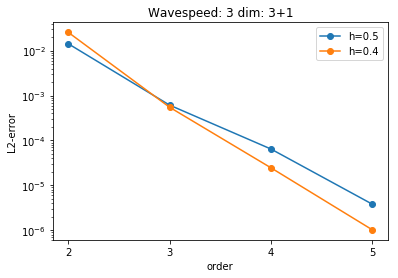

In [6]:
maxorder = 6
c = 3
t_start = 0
t_end = 1

fig = plt.figure()
ax = fig.gca()
for h in [0.5,0.4]:
    error = []
    initmesh = Mesh(unit_cube.GenerateMesh(maxh=h))
    for order in range(2,maxorder):
        wavefront = EvolveTentsMakeWavefront(order,initmesh,c,t_start)
        mat = EvolveTents(order,initmesh,c,t_end,wavefront,0)
        l2err = EvolveTentsPostProcess(order,initmesh,mat,EvolveTentsMakeWavefront(order,initmesh,c,t_end))
        error.append(l2err)
    plt.semilogy(range(2,maxorder) , error, '-o', label="h="+str(h))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Wavespeed: ' + str(c) + " dim: " + str(initmesh.dim) + "+1")
plt.legend()
plt.ylabel("L2-error")
plt.xlabel("order")
plt.show()